# KPI and Threshold Criteria Analysis

## Import simulation run data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from model.plot_utils import *
import seaborn as sns
import statsmodels.api as sm
import pickle
from pathlib import Path
import os
%matplotlib inline

In [8]:
# The 'root_dir' directory here should be the local version of 'hydra/hydra_multi_class'
root_dir = os.getcwd()

In [9]:
root_dir

'C:\\Users\\paruc\\Documents\\GitHub\\hydra\\hydra_multi_class'

In [11]:
experiment_path = root_dir + '\\experiment_block1_experiments_sigma2_20210511'

In [20]:
experiment_path = 'C:/Users/paruc/Documents/Github/hydra/hydra_multi_class/experiment_block1_experiments_sigma2_20210511.pkl'

In [19]:
# Get experiment results files stored in 'experiments' subdirectory
paths = sorted(Path(experiment_path).iterdir(), key=os.path.getmtime)

NotADirectoryError: [WinError 267] The directory name is invalid: 'C:\\Users\\paruc\\Documents\\Github\\hydra\\hydra_multi_class\\experiment_block1_experiments_sigma2_20210511.pkl'

In [21]:
# Open the most recent experiment--alternatively, substitute filename for desired experiment results file
with open(paths[-1], 'rb') as f:
    config_ids, experiments = pickle.load(f)

NameError: name 'paths' is not defined

In [22]:
experiments = pd.read_pickle ('C:/Users/paruc/Documents/Github/hydra/hydra_multi_class/experiment_block1_experiments_sigma2_20210511.pkl')

running file: asset_utils.py
end of file: asset_utils.py


In [23]:
experiments.columns

Index(['index', 'UNI_Qi', 'UNI_Ri', 'UNI_Si', 'UNI_Qj', 'UNI_Rj', 'UNI_Sj',
       'UNI_ij', 'UNI_ji', 'UNI_Sij', 'uni_agents', 'UNI_P_RQi', 'UNI_P_RQj',
       'UNI_P_ij', 'pool', 'Q', 'H', 'Wq', 'Sq', 'hydra_agents', 'C',
       'asset_random_choice', 'trade_random_size', 'simulation', 'subset',
       'run', 'substep', 'timestep'],
      dtype='object')

In [24]:
# Representative fan plot of experimental results (sanity check desired experiment was loaded)
param_fan_plot3(experiments, config_ids, 'a','Q')

NameError: name 'config_ids' is not defined

## Experiment pre-processing

### Define Slippage and Impermanent Loss calculations


#### Slippage

Slippage is calculated in two different, but related ways: the first is as an elasticity, by measuring the percentage change in the price following a trade with respect to the trade size as a percentage of the pool reserve. The second is as the percentage difference between the effective (actual trade) price and the spot price before the trade, which measures trader expectations on the execution price.

#### Impermanent Loss

Impermanent Loss (IL) is computed as the difference between the value of an amount of a single asset provided  as liquidity by an LP when exiting the pool, and the value of the intial single asset amount held outside of the pool. 


In [25]:
def slippage(assets, rdf, market):
    
    slippage = []
    elasticity = []
    res_in = []
    res_out = []
    trans_in = []
    trans_out = []
    p_out_for_in = []
    
    # Assign ids for risk assets IN and OUT for Hydra
    asset_in_ids = rdf.asset_random_choice
    asset_out_ids = pd.Series([x for y in asset_in_ids for x in assets if x != y  ])
    
    if market == 'hydra': 
        
        for t in range(0,len(asset_in_ids)-1):
            
            reserve_asset_in_prev = rdf.pool[t].pool[asset_in_ids[t]]['R']
            reserve_asset_in = rdf.pool[t+1].pool[asset_in_ids[t]]['R']
            reserve_asset_out = rdf.pool[t+1].pool[asset_out_ids[t]]['R']
            reserve_asset_out_prev = rdf.pool[t].pool[asset_out_ids[t]]['R']
            price_asset_in = rdf.pool[t+1].pool[asset_in_ids[t]]['P']
            price_asset_in_prev = rdf.pool[t].pool[asset_in_ids[t]]['P']
            price_asset_out = rdf.pool[t+1].pool[asset_in_ids[t]]['P']
            price_asset_out_prev = rdf.pool[t].pool[asset_out_ids[t]]['P']
            
            transactions_in = rdf.trade_random_size[t]
            transactions_out = -(reserve_asset_out - reserve_asset_out_prev)

            # If transactions_out or transactions_in is zero, was not a swap/trade event; return n.a.
            if transactions_out == 0 or transactions_in == 0:
                elasticity.append(np.nan)
                slippage.append(np.nan)
            else:
                # Compute percent change in reserve
                reserve_in_pct_change = transactions_in / reserve_asset_in_prev
                reserve_out_pct_change = transactions_out / reserve_asset_out_prev

                # Compute percent change in price (OUT per IN)
                price_out_for_in = price_asset_out / price_asset_in
                price_out_for_in_prev = price_asset_out_prev / price_asset_in_prev
                price_pct_change = (price_out_for_in - price_out_for_in_prev) / price_out_for_in_prev

                # Slippage calculation #1: elasticity of price with respect to transactions size
                elasticity.append(price_pct_change / reserve_in_pct_change)
                # Slippage calculation #2: percentage difference between effective and spot price

                slippage.append(((transactions_in/transactions_out) - price_out_for_in_prev) 
                                / price_out_for_in_prev)
            
            res_in.append(reserve_asset_in)
            res_out.append(reserve_asset_out)
            trans_in.append(transactions_in)
            trans_out.append(transactions_out)
            p_out_for_in.append(price_out_for_in)

        # Extract time series - clunky, refactor into comprehensions for performance
        #reserve_asset_in_dict = {}
        #reserve_asset_out_dict = {}
        #asset_price_in_dict = {}  # Note: in terms of HDX as numeraire
        #asset_price_out_dict = {} # Note: in terms of HDX as numeraire
        #asset_weight_in_dict = {}
        #asset_weight_out_dict = {}
        #for t in rdf.pool.keys():
        #    reserve_asset_in_dict[t] = rdf.pool[t].pool[asset_in_id]['R']
        #    reserve_asset_out_dict[t] = rdf.pool[t].pool[asset_out_id]['R']
        #    asset_price_in_dict[t] = rdf.pool[t].pool[asset_in_id]['P']
        #    asset_price_out_dict[t] = rdf.pool[t].pool[asset_out_id]['P']
        #    asset_weight_in_dict[t] = rdf.pool[t].pool[asset_in_id]['W']
        #    asset_weight_out_dict[t] = rdf.pool[t].pool[asset_out_id]['W']
        #reserve_asset_in = pd.Series(reserve_asset_in_dict)
        #reserve_asset_out = pd.Series(reserve_asset_out_dict)
        #asset_price_in = pd.Series(asset_price_in_dict)
        #asset_price_out = pd.Series(asset_price_out_dict)
        #asset_weight_in = pd.Series(asset_weight_in_dict)
        #asset_weight_out = pd.Series(asset_weight_out_dict)
        
        # Compute price of OUT asset in terms of IN asset
        #price_out_for_in = asset_price_out / asset_price_in

    elif market == 'uni':
        
        for t in range(0,len(asset_in_ids)-1):
            asset_in_id = 'UNI_' + str(asset_in_ids[t]) + str(asset_out_ids[t])
            asset_out_id = 'UNI_' + str(asset_out_ids[t]) + str(asset_in_ids[t])
            price_id = 'UNI_P_ij'

            reserve_asset_in = rdf[asset_in_id][t+1]
            reserve_asset_in_prev = rdf[asset_in_id][t]
            reserve_asset_out = rdf[asset_out_id][t+1]
            reserve_asset_out_prev = rdf[asset_out_id][t]
            
            transactions_in = rdf.trade_random_size[t]
            transactions_out = -(reserve_asset_out - reserve_asset_out_prev)

            # If transactions_out or transactions_in is zero, was not a swap/trade event; return n.a.
            if transactions_out == 0 or transactions_in == 0:
                elasticity.append(np.nan)
                slippage.append(np.nan)
            else:
                # Compute percent change in reserve
                reserve_in_pct_change = transactions_in / reserve_asset_in_prev
                reserve_out_pct_change = transactions_out / reserve_asset_out_prev
                # Compute percent change in price (OUT per IN)
                if asset_in_ids[t] == 'i':
                    price_out_for_in = rdf[price_id][t+1]
                    price_out_for_in_prev = rdf[price_id][t]
                elif asset_in_ids[t] == 'j':
                    price_out_for_in = 1 / rdf[price_id][t+1]
                    price_out_for_in_prev = 1 / rdf[price_id][t]
                price_pct_change = (price_out_for_in - price_out_for_in_prev) / price_out_for_in_prev

                # Slippage calculation #1: elasticity of price with respect to transactions size
                elasticity.append(price_pct_change / reserve_in_pct_change)

                # Slippage calculation #2: percentage difference between effective and spot price
                slippage.append(((transactions_in/transactions_out) - price_out_for_in_prev) 
                                / price_out_for_in_prev)
            
            res_in.append(reserve_asset_in)
            res_out.append(reserve_asset_out)
            trans_in.append(transactions_in)
            trans_out.append(transactions_out)
            p_out_for_in.append(price_out_for_in)
        
        #asset_in_id = 'UNI_R' + str(asset_in)
        #asset_out_id = 'UNI_R' + str(asset_out)
        #asset_in_swap_id = 'UNI_' + str(asset_in) + str(asset_out)
        #asset_out_swap_id = 'UNI_' + str(asset_out) + str(asset_in)
        #asset_price_in = 'UNI_P_RQ' + str(asset_in) # Note: in terms of HDX as numeraire
        #asset_price_out = 'UNI_P_RQ' + str(asset_out) # Note: in terms of HDX as numeraire
        #asset_price_swap = 'UNI_P_ij'
        
        #reserve_asset_in = rdf[asset_in_id]
        #reserve_asset_out = rdf[asset_out_id]
        #asset_price_in = rdf[asset_price_in]
        #asset_price_out = rdf[asset_price_out]
        #reserve_asset_in = rdf[asset_in_swap_id]
        #reserve_asset_out = rdf[asset_out_swap_id]
        
        #if asset_in == 'i':
        #    price_out_for_in = rdf[asset_price_swap]
        #elif asset_in == 'j':
        #    price_out_for_in = 1 / rdf[asset_price_swap]
        
        # 8 May 2021: column 'UNI_Rx' keeps track of Q <-> asset and add/remove Liquidity
        # columns 'UNI_ij' & 'UNI_ji' keep track of asset i <-> asset j swap/trades
        # To get full reserve balance effects, need to diff and update 'UNI_Rx' columns
        # reserve_asset_in = pd.Series([rdf[asset_in_id][0]])
        # reserve_asset_out = pd.Series([rdf[asset_out_id][0]])
        #for t in range(1,len(rdf[asset_in_id].diff())):
        #    add_in = pd.Series([reserve_asset_in[t-1] + rdf[asset_in_id].diff()[t] + 
        #                           rdf[asset_in_swap_id].diff()[t]])
        #    add_out = pd.Series([reserve_asset_out[t-1] + rdf[asset_out_id].diff()[t] + 
        #                           rdf[asset_out_swap_id].diff()[t]])
        #    reserve_asset_in = reserve_asset_in.append(add_in, ignore_index = True)
        #    reserve_asset_out = reserve_asset_out.append(add_out, ignore_index = True)
    
    return {
        'reserve_asset_in' : pd.Series(res_in),
        'reserve_asset_out' : pd.Series(res_out),
        'transactions_in' : pd.Series(trans_in), 
        'transactions_out' : pd.Series(trans_out),
        'price_out_for_in' : pd.Series(p_out_for_in),
        'elasticity' : pd.Series(elasticity), 
        'slippage' : pd.Series(slippage)
    }

In [26]:
def impermanent_loss(agent_id, asset_id, liquidity_added, time_entered, time_exited, rdf, market):
    
    # Set ids for asset that the LP has added
    agent_asset_id = 'r_' + str(asset_id) + '_out'
    share_id = 's_' + str(asset_id)

    # Set amount added by LP during addLiquidity event 
    # (usually set as an initial condition of the simulation)
    liquidity_added = liquidity_added

    # Set timestamp of addLiquidity event for LP
    time_liquidity_in = time_entered # Note: this is different for Uniswap agent than Hydra agent LP!

    # Set timestamp of removeLiquidity event for LP
    time_liquidity_out = time_exited
    
    # Build cumulative transactions IN amount (assumes fee eventually assessed to IN asset)
    transactions_in_cumulative = rdf.trade_random_size.cumsum()[:time_liquidity_out]
    transactions_in_cumulative.name = "transactions_in_cumulative"

    if market == 'hydra':
        
        # Get share awarded to LP from addLiquidity event
        share_rewarded = ( rdf['hydra_agents'][time_liquidity_in].iloc[agent_id][share_id] - 
                             rdf['hydra_agents'][time_liquidity_in - 1].iloc[agent_id][share_id] )

        # Compute impermanent loss over entire time series
        Ri_over_Wi = []
        Price = []
        # Build loop computing IL for every timestep
        for t in rdf['hydra_agents'].keys():
            if t <= time_liquidity_out:
                Ri_over_Wi.append(rdf.pool[t].pool[asset_id]['R'] / rdf.pool[t].pool[asset_id]['W'])
                Price.append(rdf.pool[t].pool[asset_id]['P'])
        Price = pd.Series(Price)
        Ri_over_Wi = pd.Series(Ri_over_Wi)
        Wq_over_Sq = rdf['Wq'][:time_liquidity_out] / rdf['Sq'][:time_liquidity_out]
        liquidity_removed = Wq_over_Sq.reset_index(drop=True) * Ri_over_Wi.reset_index(drop = True) * share_rewarded
        hold_value = liquidity_added * Price
        pool_value = liquidity_removed * Price
        
        # Get reserve time series for asset the LP has added
        reserve_asset_in = []
        for t in rdf.pool.keys():
            if t<= time_liquidity_out:
                reserve_asset_in.append(rdf.pool[t].pool[str(asset_id)]['R'])
        reserve_asset_in = pd.Series(reserve_asset_in, name='reserve_asset_in')
        
    elif market == 'uni':
        
        asset_reserve_key = 'UNI_R' + str(asset_id)
        asset_share_key = 'UNI_S' + str(asset_id)
        asset_price_key = 'UNI_P_RQ' + str(asset_id)
        asset_in_id = 'UNI_R' + str(asset_id)
        if asset_id == 'i':
            asset_out_id = 'j'
        elif asset_id == 'j':
            asset_out_id = 'i'
        asset_in_swap_id = 'UNI_' + str(asset_id) + str(asset_out_id)

        # Get share awarded to LP from addLiquidity event
        share_rewarded = ( rdf['uni_agents'][time_liquidity_in].iloc[agent_id][share_id] - 
                             rdf['uni_agents'][time_liquidity_in - 1].iloc[agent_id][share_id] )

        # Compute impermanent loss over entire time series

        liquidity_removed = (rdf[asset_reserve_key][:time_liquidity_out+1] / 
                               rdf[asset_share_key][:time_liquidity_out+1]) * share_rewarded
        pool_value = liquidity_removed * rdf[asset_price_key][:time_liquidity_out+1] 
        hold_value = liquidity_added * rdf[asset_price_key][:time_liquidity_out+1]
        
        # Get reserve time series for asset the LP has added
        # 8 May 2021: column 'UNI_Rx' keeps track of Q <-> asset and add/remove Liquidity
        # columns 'UNI_ij' & 'UNI_ji' keep track of asset i <-> asset j swap/trades
        # To get full reserve balance effects, need to diff and update 'UNI_Rx' columns
        #reserve_asset_out = pd.Series([rdf[asset_out_id][0]])
        reserve_asset_in = [rdf[asset_in_id][0]]
        for t in range(1,len(rdf[asset_in_id].diff())):
            if t <= time_liquidity_out:
                add_in = reserve_asset_in[t-1] + rdf[asset_in_id].diff()[t] + rdf[asset_in_swap_id].diff()[t]
            #add_out = pd.Series([reserve_asset_out[t-1] + rdf[asset_out_id].diff()[t] + 
            #                       rdf[asset_out_swap_id].diff()[t]])
                reserve_asset_in.append(add_in)
        reserve_asset_in = pd.Series(reserve_asset_in, name='reserve_asset_in')
            #reserve_asset_out = reserve_asset_out.append(add_out, ignore_index = True)
    
    IL = (pool_value / hold_value) - 1
    return {
        'pool_value' : pool_value,
        'hold_value' : hold_value,
        'impermanent_loss' : IL,
        'liquidity_removed' : liquidity_removed,
        'transactions_in_cumulative' : transactions_in_cumulative,
        'reserve_asset_in' : reserve_asset_in
    }

#### For debugging only: create one representative 'rdf' result DataFrame for subset 0 and simulation 0

In [27]:
subset_array = experiments['subset'].unique()
MC_simulation_array = experiments['simulation'].unique()
experiment_by_subset = experiments.sort_values(by=['subset']).reset_index(drop=True)
sub_ex = experiment_by_subset[experiment_by_subset['subset']==0].copy()
rdf = sub_ex[sub_ex['simulation']==0].sort_values(by=['timestep']).reset_index(drop=True).copy()


## Compute Slippage KPI time series across subsets and simulations

In [28]:
sl_kpis = {}
assets = ['i', 'j']
for subset in subset_array:
    kpi_subset = { 'Hydra' : {}, 'UNI' : {} }
    sub_experiments = experiment_by_subset[experiment_by_subset['subset']==subset].copy()
    for simulation in MC_simulation_array:
        sub_monte_carlo = sub_experiments[sub_experiments['simulation'] == simulation]
        rdf = sub_monte_carlo.sort_values(by=['timestep']).reset_index(drop=True).copy()
        # the following snippet is for future reference if fees are analyzed
        # requires that the 'config_ids' variable be saved from experiments
        # *****
        #config_rdf = [x for x in config_ids if x['simulation_id'] == simulation and 
        #              x['subset_id'] == subset][0]
        #fee = 1 - config_rdf['M']['fee_numerator']/config_rdf['M']['fee_denominator']
        # *****
        print("***Slippage calc for sim ", simulation, " of subset ", subset, "***")
        kpi_subset['Hydra'].update({simulation : slippage(assets, rdf, 'hydra')})
        kpi_subset['UNI'].update({simulation : slippage(assets, rdf, 'uni')})
    sl_kpis.update({subset: kpi_subset})

***Slippage calc for sim  0  of subset  0 ***
***Slippage calc for sim  1  of subset  0 ***
***Slippage calc for sim  2  of subset  0 ***
***Slippage calc for sim  3  of subset  0 ***
***Slippage calc for sim  4  of subset  0 ***
***Slippage calc for sim  5  of subset  0 ***
***Slippage calc for sim  6  of subset  0 ***
***Slippage calc for sim  7  of subset  0 ***
***Slippage calc for sim  8  of subset  0 ***
***Slippage calc for sim  9  of subset  0 ***
***Slippage calc for sim  10  of subset  0 ***
***Slippage calc for sim  11  of subset  0 ***
***Slippage calc for sim  12  of subset  0 ***
***Slippage calc for sim  13  of subset  0 ***
***Slippage calc for sim  14  of subset  0 ***
***Slippage calc for sim  15  of subset  0 ***
***Slippage calc for sim  16  of subset  0 ***
***Slippage calc for sim  17  of subset  0 ***
***Slippage calc for sim  18  of subset  0 ***
***Slippage calc for sim  19  of subset  0 ***
***Slippage calc for sim  20  of subset  0 ***
***Slippage calc for si

***Slippage calc for sim  81  of subset  1 ***
***Slippage calc for sim  82  of subset  1 ***
***Slippage calc for sim  83  of subset  1 ***
***Slippage calc for sim  84  of subset  1 ***
***Slippage calc for sim  85  of subset  1 ***
***Slippage calc for sim  86  of subset  1 ***
***Slippage calc for sim  87  of subset  1 ***
***Slippage calc for sim  88  of subset  1 ***
***Slippage calc for sim  89  of subset  1 ***
***Slippage calc for sim  90  of subset  1 ***
***Slippage calc for sim  91  of subset  1 ***
***Slippage calc for sim  92  of subset  1 ***
***Slippage calc for sim  93  of subset  1 ***
***Slippage calc for sim  94  of subset  1 ***
***Slippage calc for sim  95  of subset  1 ***
***Slippage calc for sim  96  of subset  1 ***
***Slippage calc for sim  97  of subset  1 ***
***Slippage calc for sim  98  of subset  1 ***
***Slippage calc for sim  99  of subset  1 ***
***Slippage calc for sim  0  of subset  2 ***
***Slippage calc for sim  1  of subset  2 ***
***Slippage cal

## Compute Impermanent Loss KPI time series across subsets and simulations

In [29]:
il_kpis = {}

# The following information should ideally be read in from e.g. 'config_ids',
# so that minimal intervention is required. Here, these are manually entered for
# the experiment being analyzed.
# **********
asset_in = 'i'
lp_agent_number = 2
liquidity_added = 50000
time_entered_hydra = 10
time_entered_uni = 10
time_exited = 90
# **********

for subset in subset_array:
    kpi_subset = { 'Hydra' : {}, 'UNI' : {} }
    sub_experiments = experiment_by_subset[experiment_by_subset['subset']==subset].copy()
    for simulation in MC_simulation_array:
        sub_monte_carlo = sub_experiments[sub_experiments['simulation'] == simulation]
        rdf = sub_monte_carlo.sort_values(by=['timestep']).reset_index(drop=True).copy()
        print("***IL calc for sim ", simulation, " of subset ", subset, "***")
        kpi_subset['Hydra'].update({simulation : impermanent_loss(
            lp_agent_number, asset_in, liquidity_added, 
            time_entered_hydra, time_exited, 
            rdf, 'hydra')})
        kpi_subset['UNI'].update({simulation : impermanent_loss(
            lp_agent_number, asset_in, liquidity_added, 
            time_entered_uni, time_exited, 
            rdf, 'uni')})
    il_kpis.update({subset: kpi_subset})

***IL calc for sim  0  of subset  0 ***
***IL calc for sim  1  of subset  0 ***
***IL calc for sim  2  of subset  0 ***
***IL calc for sim  3  of subset  0 ***
***IL calc for sim  4  of subset  0 ***
***IL calc for sim  5  of subset  0 ***
***IL calc for sim  6  of subset  0 ***
***IL calc for sim  7  of subset  0 ***
***IL calc for sim  8  of subset  0 ***
***IL calc for sim  9  of subset  0 ***
***IL calc for sim  10  of subset  0 ***
***IL calc for sim  11  of subset  0 ***
***IL calc for sim  12  of subset  0 ***
***IL calc for sim  13  of subset  0 ***
***IL calc for sim  14  of subset  0 ***
***IL calc for sim  15  of subset  0 ***
***IL calc for sim  16  of subset  0 ***
***IL calc for sim  17  of subset  0 ***
***IL calc for sim  18  of subset  0 ***
***IL calc for sim  19  of subset  0 ***
***IL calc for sim  20  of subset  0 ***
***IL calc for sim  21  of subset  0 ***
***IL calc for sim  22  of subset  0 ***
***IL calc for sim  23  of subset  0 ***
***IL calc for sim  24  of

***IL calc for sim  4  of subset  2 ***
***IL calc for sim  5  of subset  2 ***
***IL calc for sim  6  of subset  2 ***
***IL calc for sim  7  of subset  2 ***
***IL calc for sim  8  of subset  2 ***
***IL calc for sim  9  of subset  2 ***
***IL calc for sim  10  of subset  2 ***
***IL calc for sim  11  of subset  2 ***
***IL calc for sim  12  of subset  2 ***
***IL calc for sim  13  of subset  2 ***
***IL calc for sim  14  of subset  2 ***
***IL calc for sim  15  of subset  2 ***
***IL calc for sim  16  of subset  2 ***
***IL calc for sim  17  of subset  2 ***
***IL calc for sim  18  of subset  2 ***
***IL calc for sim  19  of subset  2 ***
***IL calc for sim  20  of subset  2 ***
***IL calc for sim  21  of subset  2 ***
***IL calc for sim  22  of subset  2 ***
***IL calc for sim  23  of subset  2 ***
***IL calc for sim  24  of subset  2 ***
***IL calc for sim  25  of subset  2 ***
***IL calc for sim  26  of subset  2 ***
***IL calc for sim  27  of subset  2 ***
***IL calc for sim  28

## (In progress) Plot KPI time series as fan plots, one per sweep value

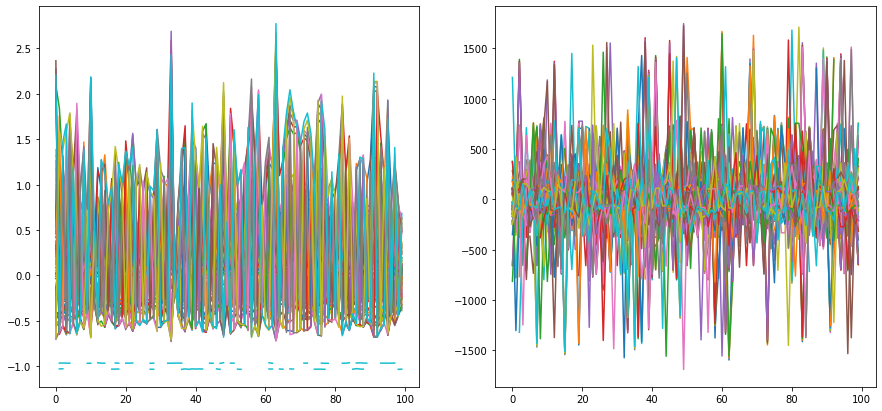

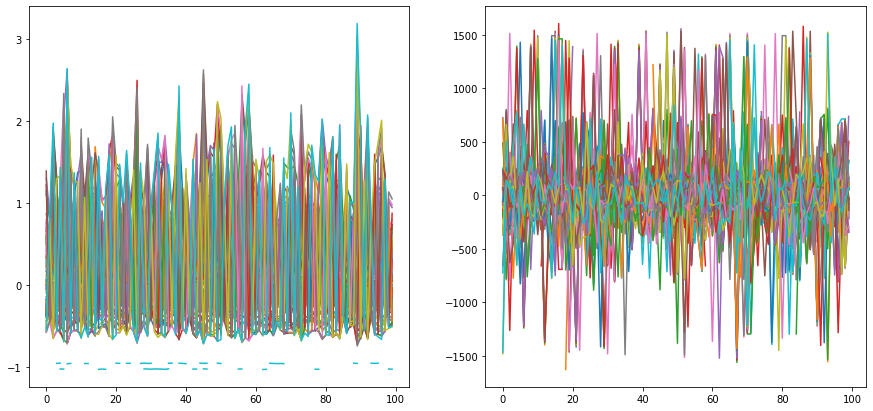

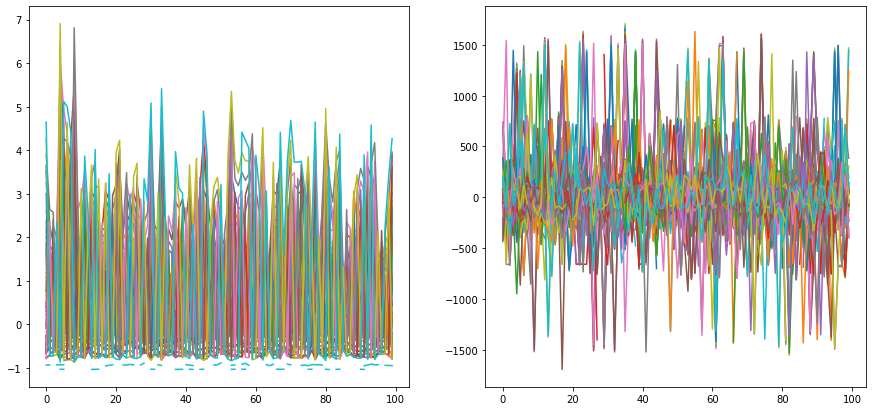

In [30]:
for subset in subset_array:
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,7))
    ax1.plot([sl_kpis[subset]['Hydra'][x]['slippage'] for x in sl_kpis[subset]['Hydra']])
    ax2.plot([sl_kpis[subset]['UNI'][x]['slippage'] for x in sl_kpis[subset]['Hydra']])

## Compute Threshold KPIs (regression results) from KPI time series
(Note that printing of regression results can be enabled/disabled using the PRINT constant)

In [31]:
PRINT = True

coeffs = {
    'slippage' : [],
    'elasticity' : [],
    'impermanent_loss' : []
}

kpi_threshold_values = {
    'Hydra' : coeffs.copy(),
    'UNI' : coeffs.copy()
}

kpi_thresholds = {}

for subset in subset_array:
    kpi_threshold_values = {
        'Hydra' : coeffs.copy(),
        'UNI' : coeffs.copy()
    }
    for simulation in MC_simulation_array:
        for market in ['Hydra', 'UNI']:
            for measure in ['elasticity', 'slippage', 'impermanent_loss']: 
            #for measure in ['impermanent_loss']: 
                if measure in ['elasticity']:
                    depvar = sl_kpis[subset][market][simulation][measure]
                    indepvar = sl_kpis[subset][market][simulation]['transactions_out']
                    xname = ['Transactions Size']
                elif measure in ['slippage']:
                    depvar = sl_kpis[subset][market][simulation][measure]
                    indepvar = sl_kpis[subset][market][simulation]['transactions_out']
                    indepvar = sm.add_constant(indepvar)
                    xname = ['Constant', 'Transactions Size']
                elif measure in ['impermanent_loss']:
                    depvar = il_kpis[subset][market][simulation][measure]
                    indepvar = pd.concat([il_kpis[subset][market][simulation]['transactions_in_cumulative'],
                                        il_kpis[subset][market][simulation]['reserve_asset_in']], axis=1)
                    indepvar = sm.add_constant(indepvar)
                    xname = ['Constant', 'Transactions Size', 'Balance Size']
                if PRINT:
                    print('********************')
                    print('Market: ', market, '; measure: ', measure)
                    print('********************')
        
                try:
                    model = sm.OLS(depvar,indepvar, missing = 'drop')
                    results = model.fit()
                    if PRINT:
                        print(results.summary(xname=xname))
                    kpi_threshold_values[market][measure].append((results.params, results.pvalues))
                except ValueError as e:
                    print('Market: ', market, ' with measure: ', measure, '; error: ', e)
    kpi_thresholds.update({subset : kpi_threshold_values})

********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.014
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              1.333
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.251
Time:                        12:22:55   Log-Likelihood:                         -513.03
No. Observations:                  98   AIC:                                      1028.
Df Residuals:                      97   BIC:                                      1031.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     563.4
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.62e-50
Time:                        12:22:55   Log-Likelihood:                 333.55
No. Observations:                  90   AIC:                            -661.1
Df Residuals:                      87   BIC:                            -653.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.012
Method:                 Least Squares   F-statistic:                              2.185
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.143
Time:                        12:22:55   Log-Likelihood:                         -520.12
No. Observations:                  98   AIC:                                      1042.
Df Residuals:                      97   BIC:                                      1045.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:55   Log-Likelihood:                 3086.6
No. Observations:                  90   AIC:                            -6167.
Df Residuals:                      87   BIC:                            -6160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     953.2
Date:                Tue, 11 May 2021   Prob (F-statistic):           6.86e-60
Time:                        12:22:56   Log-Likelihood:                 311.00
No. Observations:                  90   AIC:                            -616.0
Df Residuals:                      87   BIC:                            -608.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):             -0.006
Method:                 Least Squares   F-statistic:                             0.4364
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.510
Time:                        12:22:56   Log-Likelihood:                         -544.69
No. Observations:                 100   AIC:                                      1091.
Df Residuals:                      99   BIC:                                      1094.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:56   Log-Likelihood:                 3188.0
No. Observations:                  90   AIC:                            -6370.
Df Residuals:                      87   BIC:                            -6363.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant         

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     30.61
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.01e-07
Time:                        12:22:56   Log-Likelihood:                -591.54
No. Observations:                  93   AIC:                             1187.
Df Residuals:                      91   BIC:                             1192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     318.9
Date:                Tue, 11 May 2021   Prob (F-statistic):           8.91e-41
Time:                        12:22:56   Log-Likelihood:                 304.73
No. Observations:                  90   AIC:                            -603.5
Df Residuals:                      87   BIC:                            -596.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -0.9025      0.00

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.03102
Date:                Tue, 11 May 2021   Prob (F-statistic):              0.861
Time:                        12:22:57   Log-Likelihood:                -71.641
No. Observations:                 100   AIC:                             147.3
Df Residuals:                      98   BIC:                             152.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:57   Log-Likelihood:                 3120.4
No. Observations:                  90   AIC:                            -6235.
Df Residuals:                      87   BIC:                            -6227.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.1562
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.694
Time:                        12:22:57   Log-Likelihood:                         -131.90
No. Observations:                  92   AIC:                                      265.8
Df Residuals:                      91   BIC:                                      268.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1538.
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.32e-68
Time:                        12:22:57   Log-Likelihood:                 337.56
No. Observations:                  90   AIC:                            -669.1
Df Residuals:                      87   BIC:                            -661.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:57   Log-Likelihood:                 3071.3
No. Observations:                  90   AIC:                            -6137.
Df Residuals:                      87   BIC:                            -6129.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   3.59e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:58   Log-Likelihood:                 3031.0
No. Observations:                  90   AIC:                            -6056.
Df Residuals:                      87   BIC:                            -6049.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.005
Model:                            OLS   Adj. R-squared (uncentered):             -0.007
Method:                 Least Squares   F-statistic:                             0.4284
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.515
Time:                        12:22:58   Log-Likelihood:                         -124.73
No. Observations:                  87   AIC:                                      251.5
Df Residuals:                      86   BIC:                                      253.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     644.7
Date:                Tue, 11 May 2021   Prob (F-statistic):           6.80e-53
Time:                        12:22:58   Log-Likelihood:                 327.93
No. Observations:                  90   AIC:                            -649.9
Df Residuals:                      87   BIC:                            -642.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -0.8683      0.00

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     798.8
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.04e-56
Time:                        12:22:58   Log-Likelihood:                 335.81
No. Observations:                  90   AIC:                            -665.6
Df Residuals:                      87   BIC:                            -658.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     10.51
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00164
Time:                        12:22:58   Log-Likelihood:                 24.478
No. Observations:                  98   AIC:                            -44.96
Df Residuals:                      96   BIC:                            -39.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:59   Log-Likelihood:                 3200.8
No. Observations:                  90   AIC:                            -6396.
Df Residuals:                      87   BIC:                            -6388.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   8.47e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:59   Log-Likelihood:                 3075.4
No. Observations:                  90   AIC:                            -6145.
Df Residuals:                      87   BIC:                            -6137.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000    3.4e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:59   Log-Likelihood:                 3102.8
No. Observations:                  90   AIC:                            -6200.
Df Residuals:                      87   BIC:                            -6192.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   2.47e-1

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:22:59   Log-Likelihood:                 3240.0
No. Observations:                  90   AIC:                            -6474.
Df Residuals:                      87   BIC:                            -6467.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    st

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     7.866
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00613
Time:                        12:22:59   Log-Likelihood:                -645.20
No. Observations:                  95   AIC:                             1294.
Df Residuals:                      93   BIC:                             1300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     24.58
Date:                Tue, 11 May 2021   Prob (F-statistic):           3.11e-06
Time:                        12:23:00   Log-Likelihood:                -631.92
No. Observations:                  97   AIC:                             1268.
Df Residuals:                      95   BIC:                             1273.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             30.7809     16.76

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.012
Model:                            OLS   Adj. R-squared (uncentered):              0.002
Method:                 Least Squares   F-statistic:                              1.150
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.286
Time:                        12:23:00   Log-Likelihood:                         -137.64
No. Observations:                  96   AIC:                                      277.3
Df Residuals:                      95   BIC:                                      279.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.014
Method:                 Least Squares   F-statistic:                              2.366
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.127
Time:                        12:23:00   Log-Likelihood:                         -133.85
No. Observations:                  94   AIC:                                      269.7
Df Residuals:                      93   BIC:                                      272.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     524.3
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.92e-49
Time:                        12:23:00   Log-Likelihood:                 288.72
No. Observations:                  90   AIC:                            -571.4
Df Residuals:                      87   BIC:                            -563.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     7.289
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00819
Time:                        12:23:00   Log-Likelihood:                -33.694
No. Observations:                  99   AIC:                             71.39
Df Residuals:                      97   BIC:                             76.58
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:00   Log-Likelihood:                 3148.7
No. Observations:                  90   AIC:                            -6291.
Df Residuals:                      87   BIC:                            -6284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     2.753
Date:                Tue, 11 May 2021   Prob (F-statistic):              0.100
Time:                        12:23:01   Log-Likelihood:                -709.86
No. Observations:                  94   AIC:                             1424.
Df Residuals:                      92   BIC:                             1429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     102.6
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.31e-23
Time:                        12:23:01   Log-Likelihood:                 280.45
No. Observations:                  90   AIC:                            -554.9
Df Residuals:                      87   BIC:                            -547.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1794.
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.91e-71
Time:                        12:23:01   Log-Likelihood:                 368.38
No. Observations:                  90   AIC:                            -730.8
Df Residuals:                      87   BIC:                            -723.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -0.8812      0.00

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     578.8
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.42e-51
Time:                        12:23:01   Log-Likelihood:                 322.87
No. Observations:                  90   AIC:                            -639.7
Df Residuals:                      87   BIC:                            -632.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -0.8778      0.0

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     627.1
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.11e-52
Time:                        12:23:01   Log-Likelihood:                 318.44
No. Observations:                  90   AIC:                            -630.9
Df Residuals:                      87   BIC:                            -623.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     13.91
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000323
Time:                        12:23:02   Log-Likelihood:                -24.744
No. Observations:                  99   AIC:                             53.49
Df Residuals:                      97   BIC:                             58.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     7.355
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00795
Time:                        12:23:02   Log-Likelihood:                -679.31
No. Observations:                  96   AIC:                             1363.
Df Residuals:                      94   BIC:                             1368.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant            -52.4384     29.55

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     14.97
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000209
Time:                        12:23:02   Log-Likelihood:                -607.60
No. Observations:                  90   AIC:                             1219.
Df Residuals:                      88   BIC:                             1224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             31.0514     22.31

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     400.2
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.34e-44
Time:                        12:23:02   Log-Likelihood:                 186.30
No. Observations:                  90   AIC:                            -366.6
Df Residuals:                      87   BIC:                            -359.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.0810      0.03

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                             0.3036
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.583
Time:                        12:23:02   Log-Likelihood:                         -123.75
No. Observations:                  86   AIC:                                      249.5
Df Residuals:                      85   BIC:                                      252.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     469.9
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.33e-47
Time:                        12:23:03   Log-Likelihood:                 204.45
No. Observations:                  90   AIC:                            -402.9
Df Residuals:                      87   BIC:                            -395.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     7.032
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00943
Time:                        12:23:03   Log-Likelihood:                -662.57
No. Observations:                  94   AIC:                             1329.
Df Residuals:                      92   BIC:                             1334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              9.8124     29.05

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.003
Model:                            OLS   Adj. R-squared (uncentered):             -0.008
Method:                 Least Squares   F-statistic:                             0.2457
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.621
Time:                        12:23:03   Log-Likelihood:                         -134.26
No. Observations:                  94   AIC:                                      270.5
Df Residuals:                      93   BIC:                                      273.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     102.8
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.24e-23
Time:                        12:23:03   Log-Likelihood:                 169.18
No. Observations:                  90   AIC:                            -332.4
Df Residuals:                      87   BIC:                            -324.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.1943      0.04

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     178.0
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.78e-31
Time:                        12:23:03   Log-Likelihood:                 158.61
No. Observations:                  90   AIC:                            -311.2
Df Residuals:                      87   BIC:                            -303.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:04   Log-Likelihood:                 3045.8
No. Observations:                  90   AIC:                            -6086.
Df Residuals:                      87   BIC:                            -6078.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda

Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     16.66
Date:                Tue, 11 May 2021   Prob (F-statistic):           7.47e-07
Time:                        12:23:04   Log-Likelihood:                 147.87
No. Observations:                  90   AIC:                            -289.7
Df Residuals:                      87   BIC:                            -282.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.342
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0398
Time:                        12:23:04   Log-Likelihood:                -70.266
No. Observations:                  99   AIC:                             144.5
Df Residuals:                      97   BIC:                             149.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.0780      0.05

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.016
Model:                            OLS   Adj. R-squared (uncentered):              0.006
Method:                 Least Squares   F-statistic:                              1.607
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.208
Time:                        12:23:04   Log-Likelihood:                         -490.71
No. Observations:                  99   AIC:                                      983.4
Df Residuals:                      98   BIC:                                      986.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                            0.04828
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.827
Time:                        12:23:04   Log-Likelihood:                         -134.41
No. Observations:                  93   AIC:                                      270.8
Df Residuals:                      92   BIC:                                      273.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.2930
Date:                Tue, 11 May 2021   Prob (F-statistic):              0.590
Time:                        12:23:05   Log-Likelihood:                -57.153
No. Observations:                 100   AIC:                             118.3
Df Residuals:                      98   BIC:                             123.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -0.0006      0.04

Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:05   Log-Likelihood:                 3210.8
No. Observations:                  90   AIC:                            -6416.
Df Residuals:                      87   BIC:                            -6408.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     37.70
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.91e-08
Time:                        12:23:05   Log-Likelihood:                -599.62
No. Observations:                  97   AIC:                             1203.
Df Residuals:                      95   BIC:                             1208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     6.846
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0104
Time:                        12:23:05   Log-Likelihood:                -663.69
No. Observations:                  94   AIC:                             1331.
Df Residuals:                      92   BIC:                             1336.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     440.7
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.99e-46
Time:                        12:23:05   Log-Likelihood:                 213.68
No. Observations:                  90   AIC:                            -421.4
Df Residuals:                      87   BIC:                            -413.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:06   Log-Likelihood:                 3043.6
No. Observations:                  90   AIC:                            -6081.
Df Residuals:                      87   BIC:                            -6074.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   4.72e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     11.36
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00109
Time:                        12:23:06   Log-Likelihood:                -635.82
No. Observations:                  96   AIC:                             1276.
Df Residuals:                      94   BIC:                             1281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -2.5661     19.77

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     8.491
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00448
Time:                        12:23:06   Log-Likelihood:                -651.92
No. Observations:                  94   AIC:                             1308.
Df Residuals:                      92   BIC:                             1313.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     113.6
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.55e-25
Time:                        12:23:06   Log-Likelihood:                 171.66
No. Observations:                  90   AIC:                            -337.3
Df Residuals:                      87   BIC:                            -329.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.0826      0.03

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\ProgramData\Anaconda


********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.931
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0287
Time:                        12:23:06   Log-Likelihood:                -78.624
No. Observations:                  99   AIC:                             161.2
Df Residuals:                      97   BIC:                             166.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:06   Log-Likelihood:                 3125.0
No. Observations:                  90   AIC:                            -6244.
Df Residuals:                      87   BIC:                            -6237.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.583
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0201
Time:                        12:23:07   Log-Likelihood:                -710.41
No. Observations:                  98   AIC:                             1425.
Df Residuals:                      96   BIC:                             1430.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     192.5
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.12e-32
Time:                        12:23:07   Log-Likelihood:                 204.74
No. Observations:                  90   AIC:                            -403.5
Df Residuals:                      87   BIC:                            -396.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1804: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:903: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)
C:\ProgramData\Anaconda

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     39.64
Date:                Tue, 11 May 2021   Prob (F-statistic):           9.15e-09
Time:                        12:23:07   Log-Likelihood:                -63.950
No. Observations:                  98   AIC:                             131.9
Df Residuals:                      96   BIC:                             137.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              1.4907      0.22

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.015
Model:                            OLS   Adj. R-squared (uncentered):              0.005
Method:                 Least Squares   F-statistic:                              1.504
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.223
Time:                        12:23:07   Log-Likelihood:                         -499.39
No. Observations:                  99   AIC:                                      1001.
Df Residuals:                      98   BIC:                                      1003.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:07   Log-Likelihood:                 3139.8
No. Observations:                  90   AIC:                            -6274.
Df Residuals:                      87   BIC:                            -6266.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     4.466
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0373
Time:                        12:23:08   Log-Likelihood:                -657.27
No. Observations:                  93   AIC:                             1319.
Df Residuals:                      91   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     172.0
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.93e-31
Time:                        12:23:08   Log-Likelihood:                 155.73
No. Observations:                  90   AIC:                            -305.5
Df Residuals:                      87   BIC:                            -298.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.1129
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.738
Time:                        12:23:08   Log-Likelihood:                         -438.85
No. Observations:                  99   AIC:                                      879.7
Df Residuals:                      98   BIC:                                      882.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:08   Log-Likelihood:                 2962.5
No. Observations:                  90   AIC:                            -5919.
Df Residuals:                      87   BIC:                            -5912.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                              5.033
Date:                Tue, 11 May 2021   Prob (F-statistic):                      0.0272
Time:                        12:23:08   Log-Likelihood:                         -132.51
No. Observations:                  94   AIC:                                      267.0
Df Residuals:                      93   BIC:                                      269.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     224.5
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.48e-35
Time:                        12:23:09   Log-Likelihood:                 202.28
No. Observations:                  90   AIC:                            -398.6
Df Residuals:                      87   BIC:                            -391.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     13.91
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000324
Time:                        12:23:09   Log-Likelihood:                -152.31
No. Observations:                  99   AIC:                             308.6
Df Residuals:                      97   BIC:                             313.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.7361      0.13

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     8.392
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00466
Time:                        12:23:09   Log-Likelihood:                -98.750
No. Observations:                  99   AIC:                             201.5
Df Residuals:                      97   BIC:                             206.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     67.83
Date:                Tue, 11 May 2021   Prob (F-statistic):           8.98e-13
Time:                        12:23:09   Log-Likelihood:                -144.92
No. Observations:                  98   AIC:                             293.8
Df Residuals:                      96   BIC:                             299.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:09   Log-Likelihood:                 3175.7
No. Observations:                  90   AIC:                            -6345.
Df Residuals:                      87   BIC:                            -6338.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     15.47
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000159
Time:                        12:23:09   Log-Likelihood:                -652.33
No. Observations:                  98   AIC:                             1309.
Df Residuals:                      96   BIC:                             1314.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2057.
Date:                Tue, 11 May 2021   Prob (F-statistic):           5.62e-74
Time:                        12:23:10   Log-Likelihood:                 85.504
No. Observations:                  90   AIC:                            -165.0
Df Residuals:                      87   BIC:                            -157.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     13.84
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000334
Time:                        12:23:10   Log-Likelihood:                -129.30
No. Observations:                  99   AIC:                             262.6
Df Residuals:                      97   BIC:                             267.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:10   Log-Likelihood:                 3039.9
No. Observations:                  90   AIC:                            -6074.
Df Residuals:                      87   BIC:                            -6066.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   4.82e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:10   Log-Likelihood:                 3044.8
No. Observations:                  90   AIC:                            -6084.
Df Residuals:                      87   BIC:                            -6076.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     18.29
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.64e-05
Time:                        12:23:10   Log-Likelihood:                -600.54
No. Observations:                  94   AIC:                             1205.
Df Residuals:                      92   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.061
Model:                            OLS   Adj. R-squared (uncentered):              0.050
Method:                 Least Squares   F-statistic:                              5.877
Date:                Tue, 11 May 2021   Prob (F-statistic):                      0.0173
Time:                        12:23:11   Log-Likelihood:                         -129.60
No. Observations:                  92   AIC:                                      261.2
Df Residuals:                      91   BIC:                                      263.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.049
Model:                            OLS   Adj. R-squared (uncentered):              0.039
Method:                 Least Squares   F-statistic:                              5.054
Date:                Tue, 11 May 2021   Prob (F-statistic):                      0.0268
Time:                        12:23:11   Log-Likelihood:                         -447.58
No. Observations:                  99   AIC:                                      897.2
Df Residuals:                      98   BIC:                                      899.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     3.575
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0622
Time:                        12:23:11   Log-Likelihood:                -599.58
No. Observations:                  84   AIC:                             1203.
Df Residuals:                      82   BIC:                             1208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             60.7863     34.18

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     15.36
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000173
Time:                        12:23:11   Log-Likelihood:                -614.36
No. Observations:                  92   AIC:                             1233.
Df Residuals:                      90   BIC:                             1238.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             27.9086     20.46

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                            0.03297
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.856
Time:                        12:23:11   Log-Likelihood:                         -137.59
No. Observations:                  95   AIC:                                      277.2
Df Residuals:                      94   BIC:                                      279.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.3203
Date:                Tue, 11 May 2021   Prob (F-statistic):              0.573
Time:                        12:23:12   Log-Likelihood:                -95.236
No. Observations:                 100   AIC:                             194.5
Df Residuals:                      98   BIC:                             199.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:12   Log-Likelihood:                 3025.4
No. Observations:                  90   AIC:                            -6045.
Df Residuals:                      87   BIC:                            -6037.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     1157.
Date:                Tue, 11 May 2021   Prob (F-statistic):           2.08e-63
Time:                        12:23:12   Log-Likelihood:                 62.649
No. Observations:                  90   AIC:                            -119.3
Df Residuals:                      87   BIC:                            -111.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              5.9951      0.11

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.042
Model:                            OLS   Adj. R-squared (uncentered):              0.032
Method:                 Least Squares   F-statistic:                              4.206
Date:                Tue, 11 May 2021   Prob (F-statistic):                      0.0430
Time:                        12:23:12   Log-Likelihood:                         -139.11
No. Observations:                  98   AIC:                                      280.2
Df Residuals:                      97   BIC:                                      282.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3750
Date:                Tue, 11 May 2021   Prob (F-statistic):              0.542
Time:                        12:23:12   Log-Likelihood:                -179.31
No. Observations:                 100   AIC:                             362.6
Df Residuals:                      98   BIC:                             367.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              0.7642      0.14

********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:13   Log-Likelihood:                 3062.0
No. Observations:                  90   AIC:                            -6118.
Df Residuals:                      87   BIC:                            -6110.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     14.22
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000286
Time:                        12:23:13   Log-Likelihood:                -636.14
No. Observations:                  95   AIC:                             1276.
Df Residuals:                      93   BIC:                             1281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.009
Method:                 Least Squares   F-statistic:                             0.1444
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.705
Time:                        12:23:13   Log-Likelihood:                         -140.89
No. Observations:                  98   AIC:                                      283.8
Df Residuals:                      97   BIC:                                      286.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err  

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     448.6
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.48e-46
Time:                        12:23:13   Log-Likelihood:                 29.913
No. Observations:                  90   AIC:                            -53.83
Df Residuals:                      87   BIC:                            -46.33
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:13   Log-Likelihood:                 3051.4
No. Observations:                  90   AIC:                            -6097.
Df Residuals:                      87   BIC:                            -6089.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     895.7
Date:                Tue, 11 May 2021   Prob (F-statistic):           9.11e-59
Time:                        12:23:14   Log-Likelihood:                 52.112
No. Observations:                  90   AIC:                            -98.22
Df Residuals:                      87   BIC:                            -90.72
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant              6.3069      0.13

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.010
Method:                 Least Squares   F-statistic:                           0.007906
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.929
Time:                        12:23:14   Log-Likelihood:                         -479.69
No. Observations:                  98   AIC:                                      961.4
Df Residuals:                      97   BIC:                                      964.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     4.874
Date:                Tue, 11 May 2021   Prob (F-statistic):             0.0297
Time:                        12:23:14   Log-Likelihood:                -706.91
No. Observations:                  97   AIC:                             1418.
Df Residuals:                      95   BIC:                             1423.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     1267.
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.65e-65
Time:                        12:23:14   Log-Likelihood:                 52.383
No. Observations:                  90   AIC:                            -98.77
Df Residuals:                      87   BIC:                            -91.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  elasticity
********************
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):             -0.007
Method:                 Least Squares   F-statistic:                             0.3488
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.556
Time:                        12:23:14   Log-Likelihood:                         -439.52
No. Observations:                  99   AIC:                                      881.0
Df Residuals:                      98   BIC:                                      883.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:15   Log-Likelihood:                 3063.6
No. Observations:                  90   AIC:                            -6121.
Df Residuals:                      87   BIC:                            -6114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   3.75e-1

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:15   Log-Likelihood:                 3063.8
No. Observations:                  90   AIC:                            -6122.
Df Residuals:                      87   BIC:                            -6114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Constant             -1.0000   3.84e-1

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
********************
Market:  UNI ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                    -43.50
Date:                Tue, 11 May 2021   Prob (F-statistic):               1.00
Time:                        12:23:15   Log-Likelihood:                 3069.9
No. Observations:                  90   AIC:                            -6134.
Df Residuals:                      87   BIC:                            -6126.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    st

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  UNI ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.453
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00277
Time:                        12:23:15   Log-Likelihood:                -638.20
No. Observations:                  94   AIC:                             1280.
Df Residuals:                      92   BIC:                             1285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  impermanent_loss
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     1100.
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.73e-62
Time:                        12:23:15   Log-Likelihood:                 51.292
No. Observations:                  90   AIC:                            -96.58
Df Residuals:                      87   BIC:                            -89.08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss



********************
Market:  Hydra ; measure:  slippage
********************
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     8.841
Date:                Tue, 11 May 2021   Prob (F-statistic):            0.00372
Time:                        12:23:16   Log-Likelihood:                -95.084
No. Observations:                  99   AIC:                             194.2
Df Residuals:                      97   BIC:                             199.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


## KPI Threshold Assessment

Recall threshold criteria (as of 7 May 2021) are:
1. The estimated coefficients of the Hydra elasticity regressions should be less than one more than 80% of the MC runs.
2. The estimated coefficients of the Hydra slippage regressions should be less than the associated coefficient values of the Uniswap slippage regressions more than 80% of the MC runs, when transactions are the same across both markets.
3. The estimated constant and trade/swap transactions size coefficients of the Hydra impermanent loss regressions should be less than the associated coefficient values of the Uniswap impermanent loss regressions more than 80% of the MC runs, when transactions are the same across both markets.
4. The estimated reserve balance coefficient of the Hydra impermanent loss regressions should be statistically no different from zero for at least 80% of the MC runs.

In [32]:
# TC1
TC1 = {}
for subset in subset_array:
    mar = {}
    kpi_threshold_values = kpi_thresholds[subset]
    for market in ['Hydra', 'UNI']:
        elasticity_coeffs = kpi_threshold_values[market]['elasticity']
        satisfy = len([x for x in elasticity_coeffs[0] if x.item() < 1])
        fraction = satisfy/len(elasticity_coeffs)
        mar.update({market : fraction})
    TC1.update({ subset : mar })
print("TC1: ", TC1)

TC1:  {0: {'Hydra': 0.0033333333333333335, 'UNI': 0.0033333333333333335}, 1: {'Hydra': 0.0033333333333333335, 'UNI': 0.0033333333333333335}, 2: {'Hydra': 0.0033333333333333335, 'UNI': 0.0033333333333333335}}


In [33]:
# TC2
TC2 = {}
for subset in subset_array:
    kpi_threshold_values = kpi_thresholds[subset]
    slippage_coeffs_h = kpi_threshold_values['Hydra']['slippage']
    slippage_coeffs_u = kpi_threshold_values['UNI']['slippage']
    satisfy = len([x for i, x in enumerate(slippage_coeffs_h[0]) if
                          x['const'] < slippage_coeffs_u[0][i]['const'] and
                          x[0] < slippage_coeffs_u[0][i][0]])
    fraction = satisfy/len(slippage_coeffs_h)
    TC2.update({subset: fraction})
print("TC2: ", TC2)

TC2:  {0: 0.0, 1: 0.0, 2: 0.0}


In [34]:
# TC3, TC4
TC3 = {}; TC4 = {}
two_sided_significance = 0.05
for subset in subset_array:
    kpi_threshold_values = kpi_thresholds[subset]
    il_coeffs_h = kpi_threshold_values['Hydra']['impermanent_loss']
    il_coeffs_u = kpi_threshold_values['UNI']['impermanent_loss']
    satisfyTC3 = len([x for i, x in enumerate(il_coeffs_h[0]) if
                          x['const'] < il_coeffs_u[0][i]['const'] and
                          x['transactions_in_cumulative'] < il_coeffs_u[0][i]['transactions_in_cumulative']])
    satisfyTC4 = len([x for i, x in enumerate(il_coeffs_h[1]) if
                          x['reserve_asset_in'] < two_sided_significance])
    fractionTC3 = satisfyTC3/len(il_coeffs_h)
    fractionTC4 = satisfyTC4/len(il_coeffs_h)
    TC3.update({subset: fractionTC3})
    TC4.update({subset: fractionTC4})
print("TC3: ", TC3)
print("TC4: ", TC4)

TC3:  {0: 0.0, 1: 0.0, 2: 0.0}
TC4:  {0: 0.0016666666666666668, 1: 0.0016666666666666668, 2: 0.0016666666666666668}


## Possible future refinement: remove outliers from regresssion results using outlier test
Outlier test from: [StackOverflow](https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting)

In [35]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh